# MNIST + Simple CNN + ART: FGSM with White, Gray, Black Threat Models
This notebook focuses on FGSM only, while covering white, gray via a substitute model, and a tiny black-box demo.
Extras: accuracy vs epsilon, clean vs adversarial gallery, perturbation magnitude, confidence histograms, and confusion matrices.

## 0) Setup

In [1]:
# If needed
# !pip install torch torchvision torchaudio --upgrade
# !pip install adversarial-robustness-toolbox --upgrade

## 1) Imports and device

In [2]:
import os, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, HopSkipJump
from art.defences.preprocessor import SpatialSmoothing, JpegCompression, GaussianAugmentation, FeatureSqueezing

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 2) Data, MNIST 1x28x28

In [3]:
train_tf = T.Compose([T.ToTensor()])
test_tf  = T.Compose([T.ToTensor()])

root = './data'
train_ds = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=test_tf)

TEST_SAMPLES = 5000
test_subset = Subset(test_ds, list(range(TEST_SAMPLES)))

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_subset, batch_size=BATCH, shuffle=False, num_workers=2)

class_names = [str(i) for i in range(10)]
len(train_ds), len(test_subset)

(60000, 5000)

## 3) Simple CNN model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(64*7*7, 128), nn.ReLU(inplace=True), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Quick training for a stable baseline

In [5]:
EPOCHS = 2
for epoch in range(EPOCHS):
    model.train(); total = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(); out = model(x); loss = criterion(out, y)
        loss.backward(); optimizer.step(); total += loss.item()
        if (i+1) % 200 == 0:
            print(f'epoch {epoch+1} step {i+1} loss {total/(i+1):.4f}')

epoch 1 step 200 loss 0.4586
epoch 1 step 400 loss 0.2855
epoch 2 step 200 loss 0.0696
epoch 2 step 400 loss 0.0625


## 4) Wrap with ART classifier

In [6]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

## 5) Helpers for accuracy and plots

In [11]:
def accuracy(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item(); total += y.size(0)
    return correct/total

def predict_probs_numpy(clf, x_tensor, batch=BATCH):
    outs = []
    for i in range(0, x_tensor.size(0), batch):
        xb = x_tensor[i:i+batch].cpu().numpy()
        outs.append(clf.predict(xb))
    return np.vstack(outs)

def plot_accuracy_curve(eps_list, acc_list, title):
    plt.figure(figsize=(6,4))
    plt.plot(eps_list, acc_list, marker='o')
    plt.title(title); plt.xlabel('epsilon'); plt.ylabel('accuracy'); plt.grid(True); plt.show()

'''def plot_histogram(values, title, bins=20):
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=bins)
    plt.title(title); plt.xlabel('confidence'); plt.ylabel('count'); plt.grid(True); plt.show()

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True'); plt.colorbar(); plt.show()
'''
def show_triplet(clean, adv, title_clean, title_adv):
    plt.figure(figsize=(3,3)); plt.imshow(clean.squeeze(0).cpu().numpy(), cmap='gray'); plt.title(title_clean); plt.axis('off'); plt.show()
    plt.figure(figsize=(3,3)); plt.imshow(adv.squeeze(0).cpu().numpy(), cmap='gray'); plt.title(title_adv); plt.axis('off'); plt.show()
    delta = (adv - clean).abs().squeeze(0).cpu().numpy()
    plt.figure(figsize=(3,3)); plt.imshow(delta, cmap='gray'); plt.title('Perturbation magnitude'); plt.axis('off'); plt.show()

## 6) Baseline clean accuracy

In [8]:
clean_acc = accuracy(model, test_loader)
print(f'Clean accuracy on {len(test_subset)}: {clean_acc:.3f}')

Clean accuracy on 5000: 0.982


## 7) White-box FGSM: accuracy vs epsilon, gallery, confidence, confusion

FGSM eps 0.30 accuracy 0.072


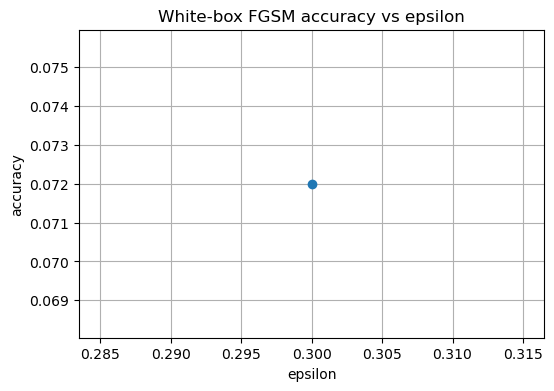

NameError: name 'show_triplet' is not defined

In [9]:
def fgsm_generate(clf, loader, eps):
    atk = FastGradientMethod(estimator=clf, eps=eps, batch_size=BATCH)
    adv_imgs, adv_lbls = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv_np = atk.generate(x=x.cpu().numpy())
        x_adv = torch.tensor(x_adv_np, dtype=x.dtype, device=device)
        adv_imgs.append(x_adv); adv_lbls.append(y)
    return torch.cat(adv_imgs, 0), torch.cat(adv_lbls, 0)

eps_list = [0.3] #0.05, 0.1, 0.15, 0.2, 0.25]
accs = []
for e in eps_list:
    adv_x, adv_y = fgsm_generate(classifier, test_loader, e)
    adv_loader = DataLoader(list(zip(adv_x, adv_y)), batch_size=BATCH, shuffle=False)
    acc = accuracy(model, adv_loader)
    accs.append(acc)
    print(f'FGSM eps {e:.2f} accuracy {acc:.3f}')
plot_accuracy_curve(eps_list, accs, 'White-box FGSM accuracy vs epsilon')

eps_vis = 0.2
x0, y0 = next(iter(test_loader))
x0 = x0.to(device); y0 = y0.to(device)
atk_vis = FastGradientMethod(estimator=classifier, eps=eps_vis, batch_size=BATCH)
x0_adv_np = atk_vis.generate(x=x0.cpu().numpy())
x0_adv = torch.tensor(x0_adv_np, dtype=x0.dtype, device=device)
for i in range(5):
    with torch.no_grad():
        pc = model(x0[i:i+1]).softmax(1)[0]; pa = model(x0_adv[i:i+1]).softmax(1)[0]
        pred_c = pc.argmax().item(); pred_a = pa.argmax().item()
        title_c = f'Clean: {class_names[pred_c]} (y={class_names[y0[i].item()]})'
        title_a = f'FGSM {eps_vis}: {class_names[pred_a]}'
    show_triplet(x0[i], x0_adv[i], title_c, title_a)

probs_clean = predict_probs_numpy(classifier, x0)
probs_adv   = predict_probs_numpy(classifier, x0_adv)
plot_histogram(probs_clean.max(1), 'Clean confidence distribution')
plot_histogram(probs_adv.max(1),   'FGSM confidence distribution')
cm_clean = confusion_matrix(y0.cpu().numpy(), probs_clean.argmax(1))
cm_adv   = confusion_matrix(y0.cpu().numpy(), probs_adv.argmax(1))
plot_confusion_matrix(cm_clean, 'Confusion matrix, clean batch')
plot_confusion_matrix(cm_adv,   'Confusion matrix, FGSM batch')

## 8) Gray-box FGSM via substitute model and transfer

Gray-box transfer FGSM acc at eps 0.2: 0.854


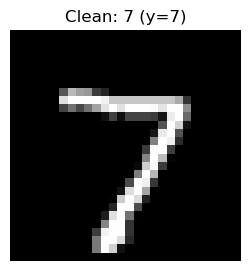

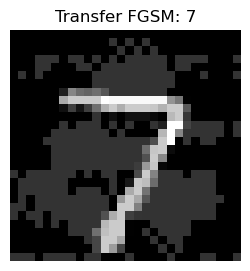

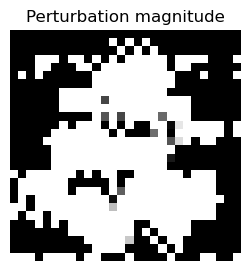

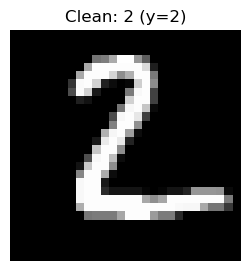

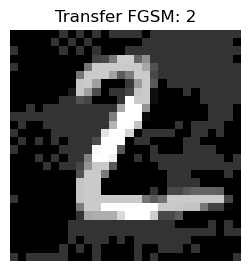

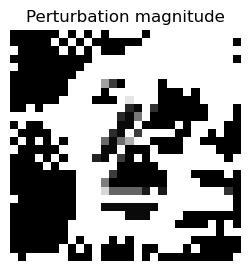

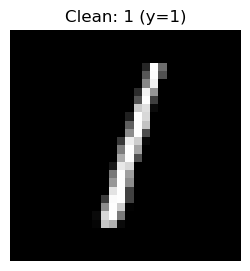

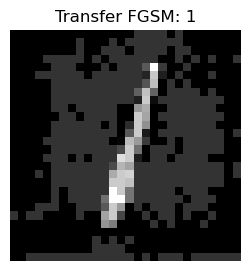

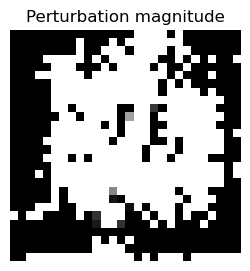

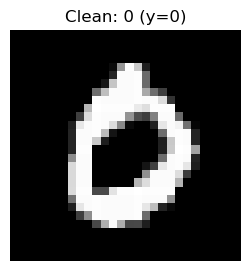

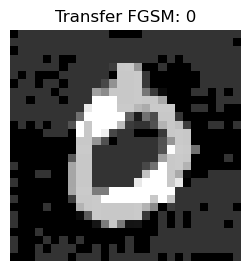

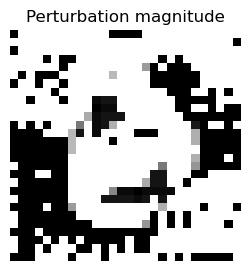

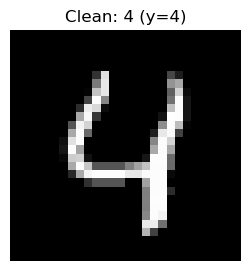

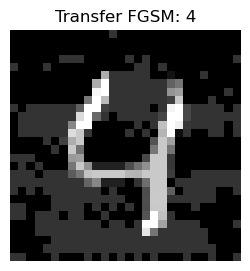

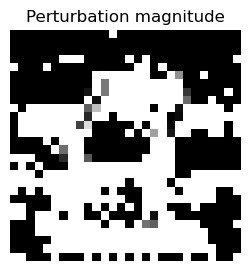

In [12]:
surrogate = SimpleCNN().to(device)
opt_surr = optim.Adam(surrogate.parameters(), lr=1e-3)
crit_surr = nn.CrossEntropyLoss()

SUBSET = 8000
surr_loader = DataLoader(Subset(train_ds, list(range(SUBSET))), batch_size=128, shuffle=True)
for epoch in range(1):
    surrogate.train()
    for x, y in surr_loader:
        x, y = x.to(device), y.to(device)
        opt_surr.zero_grad(); out = surrogate(x); loss = crit_surr(out, y)
        loss.backward(); opt_surr.step()

surr_clf = PyTorchClassifier(model=surrogate, clip_values=(0,1), loss=crit_surr, optimizer=opt_surr, input_shape=(1,28,28), nb_classes=10)

eps_g = 0.2
fgsm_surr = FastGradientMethod(estimator=surr_clf, eps=eps_g, batch_size=BATCH)
adv_imgs, adv_lbls = [], []
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    x_adv_np = fgsm_surr.generate(x=x.cpu().numpy())
    adv_imgs.append(torch.tensor(x_adv_np, dtype=x.dtype, device=device)); adv_lbls.append(y)
adv_x_t = torch.cat(adv_imgs, 0); adv_y_t = torch.cat(adv_lbls, 0)
transfer_loader = DataLoader(list(zip(adv_x_t, adv_y_t)), batch_size=BATCH, shuffle=False)
acc_transfer = accuracy(model, transfer_loader)
print(f'Gray-box transfer FGSM acc at eps {eps_g}: {acc_transfer:.3f}')

xg, yg = next(iter(test_loader))
xg = xg.to(device); yg = yg.to(device)
xg_adv_np = fgsm_surr.generate(x=xg.cpu().numpy())
xg_adv = torch.tensor(xg_adv_np, dtype=xg.dtype, device=device)
for i in range(5):
    pred_c = model(xg[i:i+1]).argmax(1).item(); pred_a = model(xg_adv[i:i+1]).argmax(1).item()
    show_triplet(xg[i], xg_adv[i], f'Clean: {class_names[pred_c]} (y={class_names[yg[i].item()]})', f'Transfer FGSM: {class_names[pred_a]}')

## 9) Black-box tiny demo, decision based

In [13]:
TINY = 64
x_bb, y_bb = next(iter(DataLoader(test_subset, batch_size=TINY)))
x_bb = x_bb.to(device); y_bb = y_bb.to(device)
hsj = HopSkipJump(classifier=classifier, max_iter=10)
x_bb_adv_np = hsj.generate(x=x_bb.cpu().numpy())
x_bb_adv = torch.tensor(x_bb_adv_np, dtype=x_bb.dtype, device=device)

bb_loader = DataLoader(list(zip(x_bb, y_bb)), batch_size=TINY)
bb_adv_loader = DataLoader(list(zip(x_bb_adv, y_bb)), batch_size=TINY)
acc_bb_clean = accuracy(model, bb_loader)
acc_bb_adv   = accuracy(model, bb_adv_loader)
print(f'Black-box tiny batch, clean {acc_bb_clean:.3f}, HSJ adversarial {acc_bb_adv:.3f}')

HopSkipJump:   0%|          | 0/64 [00:00<?, ?it/s]

Black-box tiny batch, clean 0.984, HSJ adversarial 0.000


## 10) Quick defenses at inference time

In [14]:
def acc_with_defence(preproc, name, x_clean, y_clean, x_adv, y_adv):
    clf = PyTorchClassifier(model=model, clip_values=(0,1), loss=criterion, optimizer=optimizer, input_shape=(1,28,28), nb_classes=10, preprocessing_defences=preproc)
    def np_acc(x_tensor, y_tensor):
        correct, total = 0, 0
        for i in range(0, x_tensor.size(0), BATCH):
            xb = x_tensor[i:i+BATCH].cpu().numpy(); yb = y_tensor[i:i+BATCH].cpu().numpy()
            pred = clf.predict(xb).argmax(1)
            correct += (pred == yb).sum(); total += yb.shape[0]
        return correct/total
    a_clean = np_acc(x_clean, y_clean); a_adv = np_acc(x_adv, y_adv)
    print(f'[{name}] clean {a_clean:.3f} adv {a_adv:.3f} delta {(a_clean-a_adv):.3f}')
    return a_clean, a_adv

def_jpeg     = JpegCompression(clip_values=(0,1), quality=60)
def_smooth   = SpatialSmoothing(window_size=3)
def_squeeze  = FeatureSqueezing(clip_values=(0,1), bit_depth=4, apply_fit=False, apply_predict=True)
def_gaussian = GaussianAugmentation(sigma=0.05, augmentation=False)

x_demo, y_demo = next(iter(test_loader))
x_demo = x_demo.to(device); y_demo = y_demo.to(device)
fgsm_demo = FastGradientMethod(estimator=classifier, eps=0.2, batch_size=BATCH)
x_demo_adv_np = fgsm_demo.generate(x=x_demo.cpu().numpy())
x_demo_adv = torch.tensor(x_demo_adv_np, dtype=x_demo.dtype, device=device)

acc_with_defence(def_jpeg,     'JPEG-60',       x_demo, y_demo, x_demo_adv, y_demo)
acc_with_defence(def_smooth,   'SpatialSmooth', x_demo, y_demo, x_demo_adv, y_demo)
acc_with_defence(def_squeeze,  'FeatureSqueeze',x_demo, y_demo, x_demo_adv, y_demo)
acc_with_defence(def_gaussian, 'GaussianNoise', x_demo, y_demo, x_demo_adv, y_demo)

[JPEG-60] clean 0.992 adv 0.445 delta 0.547
[SpatialSmooth] clean 0.984 adv 0.516 delta 0.469
[FeatureSqueeze] clean 0.992 adv 0.438 delta 0.555
[GaussianNoise] clean 0.992 adv 0.438 delta 0.555


(0.9921875, 0.4375)

## 11) Summary

In [15]:
print('Summary:')
print(f'Clean accuracy: {clean_acc:.3f}')
print('Used FGSM only across white, gray with a substitute model, and a tiny black-box demo. Added visuals and inference-time defenses.')

Summary:
Clean accuracy: 0.982
Used FGSM only across white, gray with a substitute model, and a tiny black-box demo. Added visuals and inference-time defenses.
